In [1]:
file_path = 'enron1/ham/0007.1999-12-14.farmer.ham.txt'

with open(file_path, 'r') as infile:
    ham_sample = infile.read()
    
print(ham_sample)

In [2]:
import glob

mails = []
labels = []

for filename in glob.glob('enron1/spam/*.txt'):
    with open(filename, 'r', encoding='iso-8859-1') as infile:
        mails += [infile.read()]
        labels += [1]
        
for filename in glob.glob('enron1/ham/*.txt'):
    with open(filename, 'r', encoding='iso-8859-1') as infile:
        mails += [infile.read()]
        labels += [0]

In [3]:
import nltk

nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Jae\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jae\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        lemmatized_list = [lemmatizer.lemmatize(word.lower()) for word in doc.split() 
                           if word.isalpha() and word not in all_names]
        cleaned_docs += [' '.join(lemmatized_list)]
        
    return cleaned_docs

cleaned_mails = clean_text(mails)

In [5]:
cleaned_mails[0]

'dobmeos with hgh my energy level ha gone up stukm introducing doctor formulated hgh human growth hormone also called hgh is referred to in medical science a the master hormone it is very plentiful when we are young but near the age of twenty one our body begin to produce le of it by the time we are forty nearly everyone is deficient in hgh and at eighty our production ha normally diminished at least advantage of hgh increased muscle strength loss in body fat increased bone density lower blood pressure quickens wound healing reduces cellulite improved vision wrinkle disappearance increased skin thickness texture increased energy level improved sleep and emotional stability improved memory and mental alertness increased sexual potency resistance to common illness strengthened heart muscle controlled cholesterol controlled mood swing new hair growth and color restore read more at this website unsubscribe'

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cleaned_mails,
                                                   labels,
                                                   test_size = 0.2,
                                                   random_state = 0)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_features=500)
term_docs_train = cv.fit_transform(X_train)
term_docs_test = cv.transform(X_test)

In [8]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(alpha= 1.0, fit_prior= True)
clf.fit(term_docs_train, y_train)

MultinomialNB()

In [9]:
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob

array([[1.00000000e+00, 2.76054897e-11],
       [2.14389262e-02, 9.78561074e-01],
       [3.86654914e-13, 1.00000000e+00],
       ...,
       [3.52881971e-07, 9.99999647e-01],
       [1.00000000e+00, 8.26919077e-30],
       [1.00000000e+00, 2.66928620e-10]])

In [10]:
prediction = clf.predict(term_docs_test)
prediction

array([0, 1, 1, ..., 1, 0, 0])

In [11]:
from sklearn.metrics import confusion_matrix

prediction = clf.predict(term_docs_test)
confusion_matrix(y_test, prediction, labels = [0,1])

array([[674,  51],
       [ 36, 274]], dtype=int64)

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = clf.score(term_docs_test, y_test)
print('Accuracy: {:.1f}%'.format(accuracy*100))

precision = precision_score(y_test, prediction, pos_label=1)
print('Precision: {:.1f}%'.format(precision*100))

recall = precision_score(y_test, prediction, pos_label=1)
print('Recall: {:.1f}%'.format(recall*100))

f1 = precision_score(y_test, prediction, pos_label=1)
print('F1-score: {:.1f}%'.format(f1*100))

Accuracy: 91.6%
Precision: 84.3%
Recall: 84.3%
F1-score: 84.3%


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       725
           1       0.84      0.88      0.86       310

    accuracy                           0.92      1035
   macro avg       0.90      0.91      0.90      1035
weighted avg       0.92      0.92      0.92      1035



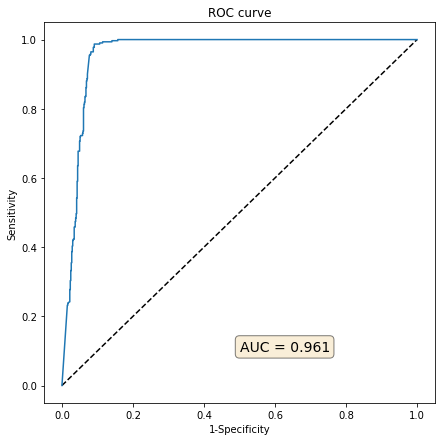

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                        prediction_prob[:,1],
                                        pos_label=1)
fig, ax = plt.subplots(figsize=(7,7))
ax.plot([0,1], [0,1], 'k--')
ax.plot(fpr, tpr)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC curve')

auc = metrics.roc_auc_score(y_test, prediction_prob[:,1])
textstr = 'AUC = {:.3f}'.format(auc)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.5, 0.1, textstr, fontsize=14, bbox=props)

plt.show()

In [15]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

k_fold = StratifiedKFold(n_splits=5)
cleaned_mails_arr, labels_arr = np.array(cleaned_mails), np.array(labels)

In [16]:
for k, (cv_trn_idx, cv_test_idx) in enumerate(k_fold.split(cleaned_mails_arr, labels_arr)):
    cv_train_X = cleaned_mails_arr[cv_trn_idx]
    cv_train_y = labels_arr[cv_trn_idx]
    cv_term_docs_train = cv.fit_transform(cv_train_X)
    
    clf.fit(cv_term_docs_train, cv_train_y)
    
    cv_test_X = cleaned_mails_arr[cv_test_idx]
    cv_test_y = labels_arr[cv_test_idx]
    cv_term_docs_test = cv.transform(cv_test_X)
    
    accuracy = clf.score(cv_term_docs_test, cv_test_y)
    
    print('#{} Accuracy: {:.4f}'.format(k+1, accuracy))

#1 Accuracy: 0.9140
#2 Accuracy: 0.9372
#3 Accuracy: 0.9284
#4 Accuracy: 0.9159
#5 Accuracy: 0.8878


In [17]:
accuracy.mean()

0.8878143133462283